<a href="https://colab.research.google.com/github/Niko-k98/Machine-Learning-class/blob/Machine-learning-class/BML_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom as dicom
!pip install monai


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib.patches import Ellipse
from skimage import io, color, measure, draw, img_as_bool
from scipy import optimize
import pandas as pd
from skimage import color

import pydicom as dicom
import torch
from PIL import Image
from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter
from torch import nn
import torch.nn.functional as F

import keras
import keras_preprocessing



init_notebook_mode(connected=True)

In [ ]:
'''
destinations of different patients
/content/drive/Shareddrives/BML Clinc/Dataset/Patient1
/content/drive/Shareddrives/BML Clinc/Dataset/Bradford, Sandra
/content/drive/Shareddrives/BML Clinc/Dataset/Mance, Dorothy
/content/drive/Shareddrives/BML Clinc/Dataset/Pryor_Kenneth
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley '''

'\ndestinations of different patients\n/content/drive/Shareddrives/BML Clinc/Dataset/Patient1\n/content/drive/Shareddrives/BML Clinc/Dataset/Bradford, Sandra\n/content/drive/Shareddrives/BML Clinc/Dataset/Mance, Dorothy\n/content/drive/Shareddrives/BML Clinc/Dataset/Pryor_Kenneth\n/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley '

In [ ]:
#Loads all the data in the Dataset dirctory 1236 CT images 
'''import glob
data_path = "/content/drive/Shareddrives/BML Clinc/Dataset"
output_path = working_path = "/content/drive/MyDrive/BML learning"
g = glob.glob( data_path + '/**/*.dcm', recursive=True)

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print('\n'.join(g[:5]))'''

'import glob\ndata_path = "/content/drive/Shareddrives/BML Clinc/Dataset"\noutput_path = working_path = "/content/drive/MyDrive/BML learning"\ng = glob.glob( data_path + \'/**/*.dcm\', recursive=True)\n\nprint("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))\nprint(\'\n\'.join(g[:5]))'

In [ ]:
'''/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_rr_fs_sag_320
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_cor_320
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t1_se_cor_384
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/pd_tse_sag_448'''

'/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_rr_fs_sag_320\n/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320\n/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_cor_320\n/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t1_se_cor_384\n/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/pd_tse_sag_448'

In [ ]:
#Declare path
data_path = "/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320"
output_path = working_path = "/content/drive/MyDrive/BML learning"
g = glob(data_path + "/*")

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print('\n'.join(g[:5]))

Total no. of CT images are: 32 
First 5 elements:
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320/14629.dcm
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320/14636.dcm
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320/14635.dcm
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320/14637.dcm
/content/drive/Shareddrives/BML Clinc/Dataset/Zerbe, Bradley/t2_tse_fs_tra_320/14631.dcm


In [ ]:
#load image slices for patient folder
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    aa=[]
    for s in os.listdir(path):
        aa.append(s)
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
       slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return aa, slices
    
#store HU units pixel array in numpy format for processing
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept if 'RescaleIntercept' in scans[0] else -1024
    slope = scans[0].RescaleSlope if 'RescaleSlope' in scans[0] else 1
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


id=17
aa, patient = load_scan(data_path)
imgs = get_pixels_hu(patient)


In [ ]:
#save images in numpy format
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

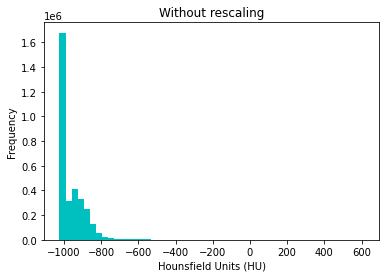

In [ ]:
#graph of HU units
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.title('Without rescaling')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#slice thickness of image slices
table=[]
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    for s in slices:
        table.append(s.SliceThickness)
    return table

In [ ]:
ag = dicom.read_file("/content/drive/Shareddrives/BML Clinc/Dataset/Patient1/IM-0001-0001.dcm")

In [ ]:
ag.PixelSpacing


[0.5, 0.5]

In [ ]:
#check table height, may not be relevant?
table=[]
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    for s in slices:
        table.append(s.TableHeight)
    return table

In [ ]:
tablet = load_scan(data_path) if 'TableHeight' in data_path[0] else [1]

In [ ]:
np.unique(tablet)

array([1])

In [ ]:
#create a max image
imgs = imgs+1024
imgs=imgs.astype("float32")

In [ ]:
imgs_max = imgs.max(0)

In [ ]:
imgs_maxxx = np.zeros_like(imgs_max,dtype='float32')
max_im = float(imgs_max.max())
imgs_maxxx = imgs_max/max_im

In [ ]:
#currently doesnt compile error: Unknown file extenstion
#plt.imsave("Max_Image_31",imgs_maxxx)

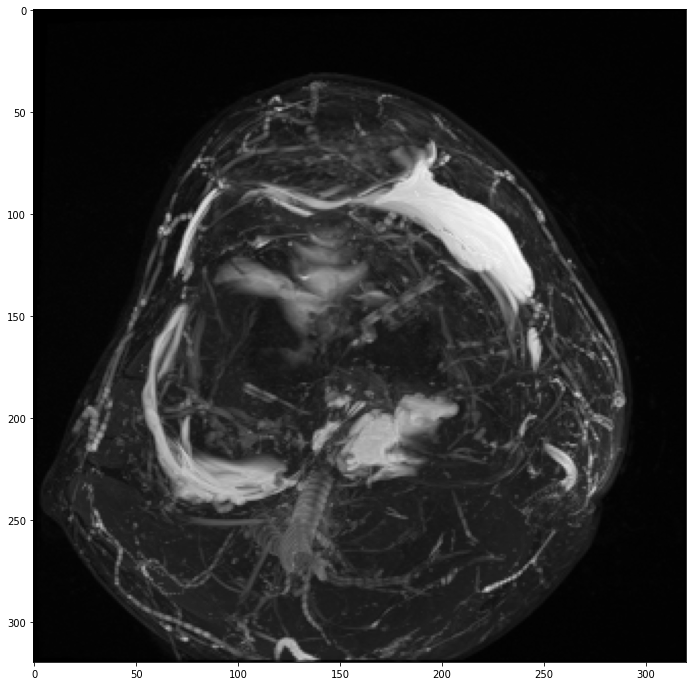

In [ ]:
#MAX value representation
fig,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(imgs_maxxx,cmap=plt.cm.gray)
plt.show()

In [ ]:
#generate Mean image from 31 images

mean_im = np.zeros_like(imgs[0])
for i in imgs:
    mean_im += i
mean_im = np.divide(mean_im,2490)

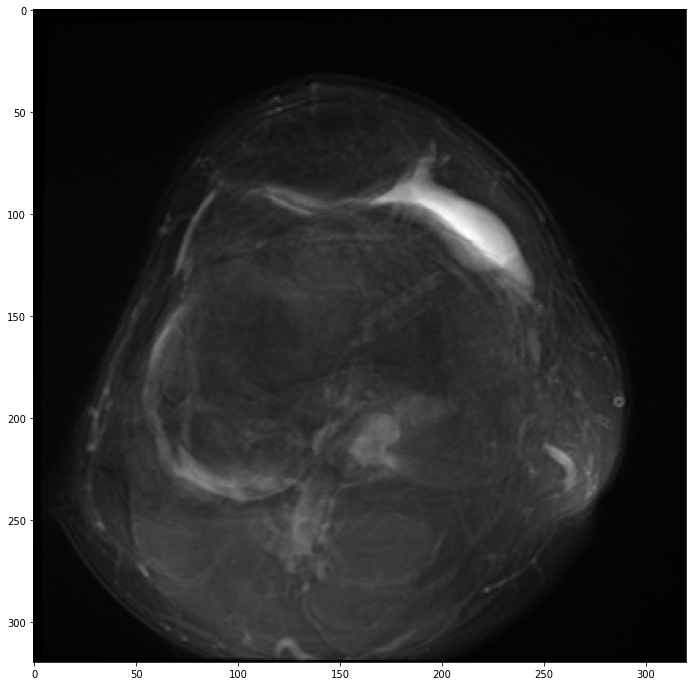

In [ ]:
#Mean Value representation
fig,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(mean_im,cmap=plt.cm.gray)
plt.show()


In [ ]:
id = 17
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

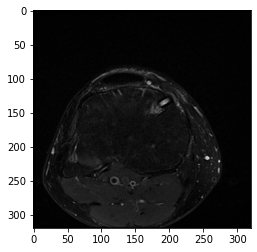

In [ ]:
#data visualization 
a = imgs[23]
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

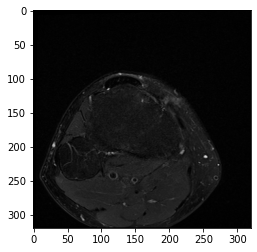

In [ ]:
a = imgs[26]
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

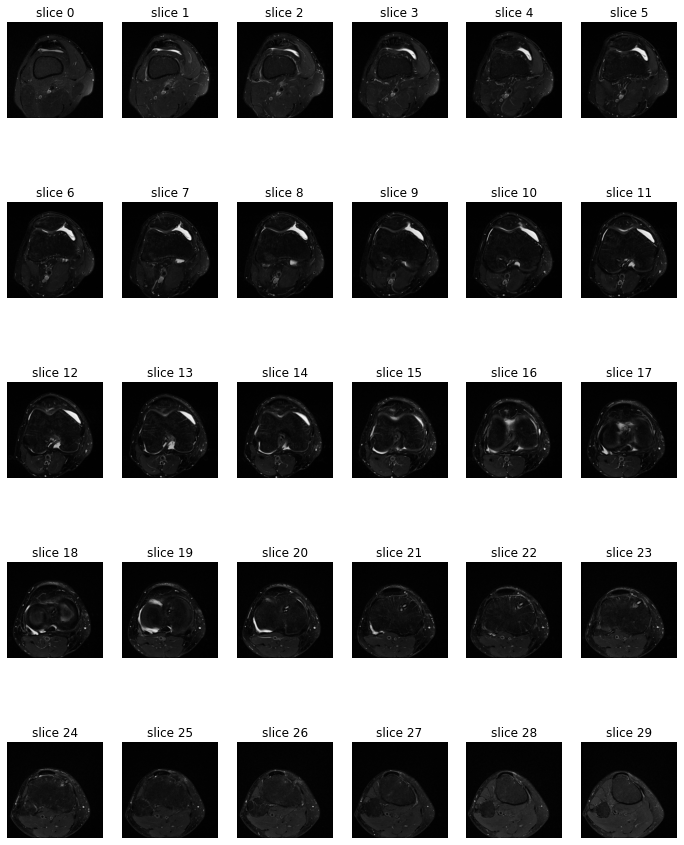

AttributeError: ignored

In [ ]:
def sample_stack(stack, rows=5, cols=6):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(imgs).


In [ ]:
#will require Semantic segmentation

In [ ]:
#Implement Transfer Learning with U-net model

In [ ]:
#to be determined